#Radial Basis Function Network (RBF) for Regression

### Synthetic Data Generation

we'll generate our synthetic dataset using a mixture of Gaussian functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

In [ ]:
def mog1D_gen(Npatterns=200, visualize=True):
    """
    Generates a 1D Mixture of Gaussians synthetic dataset

    Parameters:
    - Npatterns: Number of data points to generate
    - visualize: Whether to plot the generated data

    Returns:
    - X: Input features (Npatterns x 1)
    - y: Target values (Npatterns x 1)
    """
    X = np.linspace(-10, 10, Npatterns).reshape(-1, 1)

    # Define parameters for three Gaussian kernels
    centre1, centre2, centre3 = -8, -1, 7
    ampl1, ampl2, ampl3 = 3, -5, 9
    epsilon = 0.3

    # Compute each kernel component
    k1 = ampl1 * np.exp(-((X - centre1) * epsilon)**2)
    k2 = ampl2 * np.exp(-((X - centre2) * epsilon)**2)
    k3 = ampl3 * np.exp(-((X - centre3) * epsilon)**2)

    # Combine kernels to form target output
    y = k1 + k2 + k3

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.plot(X, k1, 'ob', label=f'kernel 1 (centre={centre1}, amplitude={ampl1})')
        plt.plot(X, k2, 'sr', label=f'kernel 2 (centre={centre2}, amplitude={ampl2})')
        plt.plot(X, k3, '^g', label=f'kernel 3 (centre={centre3}, amplitude={ampl3})')
        plt.plot(X, y, '.k', label='Combined output y')
        plt.legend(fontsize=12)
        plt.title('1D Mixture of Gaussians Synthetic Dataset', fontsize=14)
        plt.xlabel('Input X', fontsize=12)
        plt.ylabel('Output y', fontsize=12)
        plt.grid(True)
        plt.show()

    return X, y

### RBF Network Core Functions



In [ ]:
def RBF_extend(X):
    """
    Extends the input matrix by adding a row of ones (bias term)

    Parameters:
    - X: Input matrix (n_features x n_samples)

    Returns:
    - Extended matrix with bias term ((n_features+1) x n_samples)
    """
    return np.vstack([np.ones(X.shape[1]), X])


In [ ]:
def RBF_forward(P, W1, W2, epsilon):
    """
    Forward pass of the RBF network

    Parameters:
    - P: Input patterns (n_samples x n_features)
    - W1: Centers matrix (n_hidden x n_features)
    - W2: Output weights (1 x (n_hidden+1))
    - epsilon: Width parameter for Gaussian RBFs

    Returns:
    - rA2: Network output (1 x n_samples)
    - A1: Extended hidden layer outputs ((n_hidden+1) x n_samples)
    """
    rA0 = P.T  # Transpose input matrix (D x B)
    # Compute Euclidean distances between each pattern and each center
    rZ1 = np.sqrt(np.sum((W1[:, :, np.newaxis] - rA0[np.newaxis, :, :])**2, axis=1))
    # Apply Gaussian activation function
    rA1 = np.exp(-(epsilon**2 * (rZ1**2)))
    # Extend hidden layer outputs with bias term
    A1 = RBF_extend(rA1)
    # Compute output layer pre-activation
    rZ2 = W2 @ A1
    # Output (linear activation)
    rA2 = rZ2

    return rA2, A1

In [ ]:
def RBF_initialize_centres(model, Xtrain, ytrain):
    """
    Initializes the RBF centers based on the specified method

    Parameters:
    - model: Dictionary containing model parameters
    - Xtrain: Training inputs (n_samples x n_features)
    - ytrain: Training targets (n_samples x 1)

    Returns:
    - model: Updated model dictionary
    - W1: Centers matrix (n_hidden x n_features)
    """
    method = model['centres_generation_method']
    n_hidden = model['n_hidden']

    if method == 'random':
        # Randomly select training points as centers
        idx = np.random.permutation(Xtrain.shape[0])
        W1 = Xtrain[idx[:n_hidden], :]
    elif method == 'clustering':
        # K-means clustering for center initialization
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=n_hidden, max_iter=50, tol=0.001)
        print('Clustering training data using K-means...')
        kmeans.fit(Xtrain)
        W1 = kmeans.cluster_centers_
        print('Clustering completed - centers initialized')
    elif method == 'debug':
        # Fixed centers for debugging
        if n_hidden != 3:
            print('Warning: Forcing n_hidden=3 for debug mode')
            model['n_hidden'] = 3
            n_hidden = 3

        if Xtrain.shape[1] == 1:
            W1 = np.array([[-8], [-1], [7]])
        elif Xtrain.shape[1] == 2:
            W1 = np.array([[-8, -8], [-1, -1], [7, 7]])
        else:
            raise ValueError('Unsupported input dimension for debug mode')
    else:
        raise ValueError('Unrecognized center generation method')

    model['W1'] = W1
    return model, W1

In [ ]:
def RBF_train_offline(X, y, model):
    """
    Trains the RBF network in two phases:
    1. Center initialization
    2. Output weight computation via least squares

    Parameters:
    - X: Training inputs (n_samples x n_features)
    - y: Training targets (n_samples x 1)
    - model: Model configuration dictionary

    Returns:
    - model: Updated model with trained parameters
    - W1: Centers matrix (n_hidden x n_features)
    - W2: Output weights (1 x (n_hidden+1))
    """
    # Phase 1: Center initialization
    model, W1 = RBF_initialize_centres(model, X, y)

    # Phase 2: Compute output weights via least squares
    # Forward pass to get hidden layer outputs
    _, A1 = RBF_forward(X, W1, np.ones((1, model['n_hidden'] + 1)), model['epsilon'])

    # Reshape y to match expected dimensions (n_samples,) instead of (n_samples, 1)
    y_flat = y.ravel()

    # Solve least squares problem for output weights
    W2 = np.linalg.lstsq(A1.T, y_flat, rcond=None)[0]
    W2 = W2.reshape(1, -1)  # Ensure W2 is (1 x (n_hidden+1))

    model['W2'] = W2
    return model, W1, W2


In [ ]:
def RBF_predict(X, W1, W2, epsilon):
    """
    Makes predictions using the trained RBF network

    Parameters:
    - X: Input patterns (n_samples x n_features)
    - W1: Centers matrix (n_hidden x n_features)
    - W2: Output weights (1 x (n_hidden+1))
    - epsilon: Width parameter for Gaussian RBFs

    Returns:
    - Predictions (1 x n_samples)
    """
    y_pred, _ = RBF_forward(X, W1, W2, epsilon)
    return y_pred

### Data Generation and Visualization

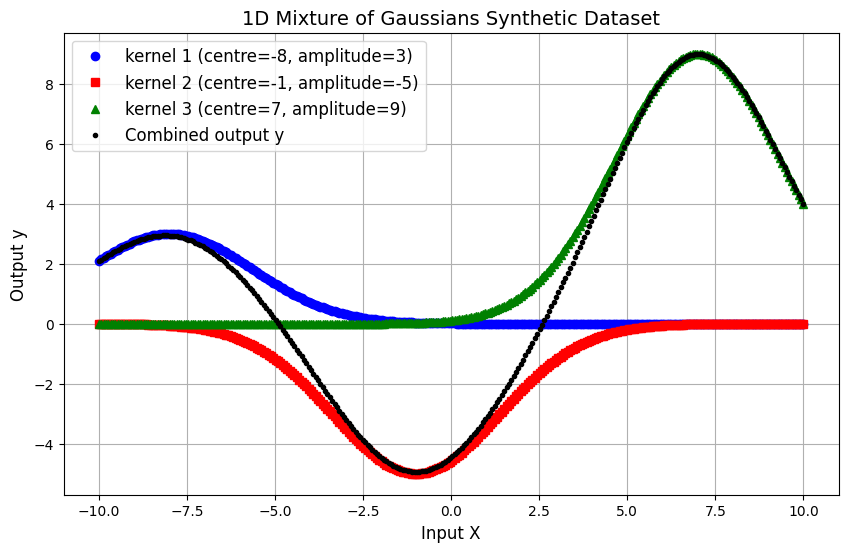

In [ ]:
# Generate training and test data
Ntrain = 300
Ntest = 200
Xtrain, ytrain = mog1D_gen(Ntrain, True)
Xtest, ytest = mog1D_gen(Ntest, False)


### Model Configuration


In [ ]:
# Initialize model parameters
model = {
    'n_output': 1,                  # Single output regression
    'n_features': 1,                # 1D input
    'n_hidden': 30,                 # Number of RBF centers
    'epsilon': 0.3,                 # RBF width parameter
    'centres_generation_method': 'clustering'  # Center initialization method
    # Alternatives: 'random', 'debug'
}

### Model Training

In [ ]:
# Train the RBF network
model, W1, W2 = RBF_train_offline(Xtrain, ytrain, model)


Clustering training data using K-means...
Clustering completed - centers initialized


### Prediction and Evaluation

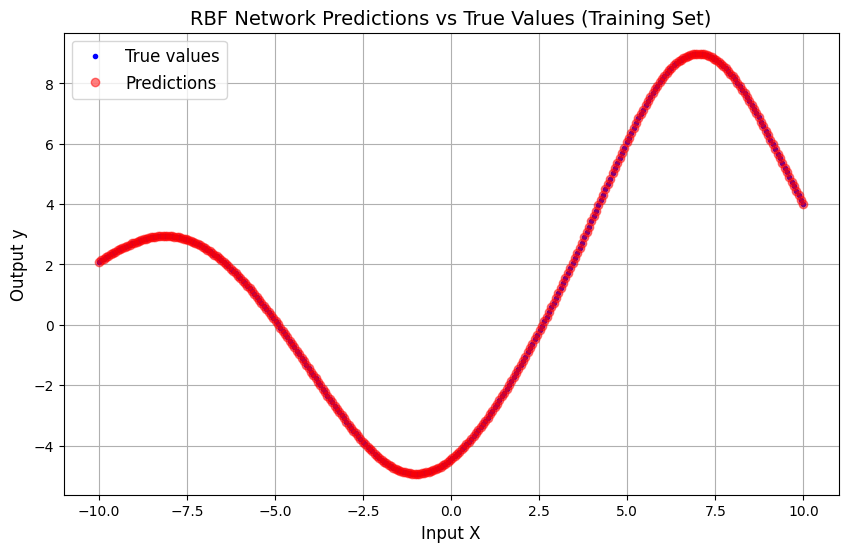

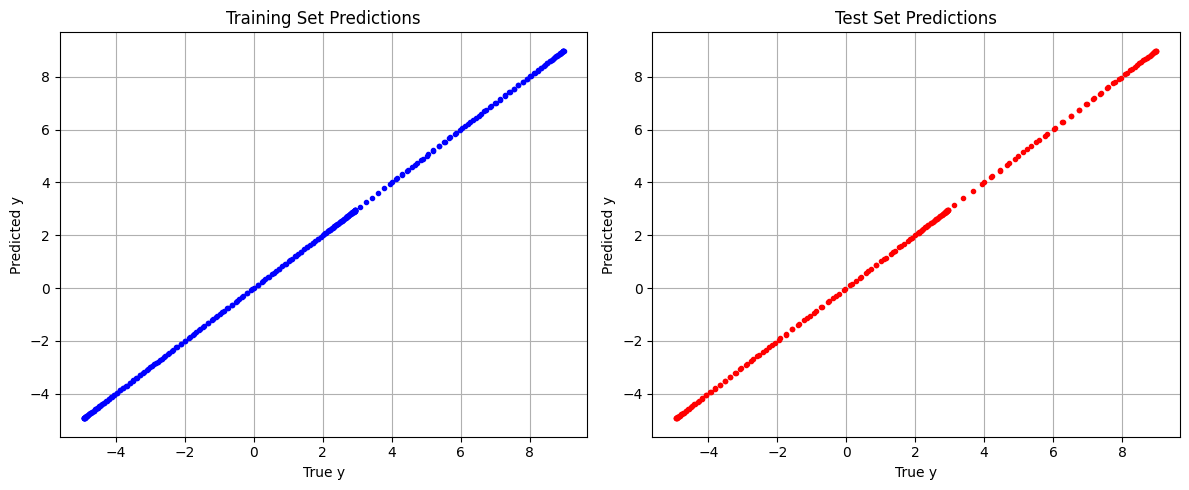

In [ ]:
# Make predictions
ytrain_pred = RBF_predict(Xtrain, W1, W2, model['epsilon'])
ytest_pred = RBF_predict(Xtest, W1, W2, model['epsilon'])

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(Xtrain, ytrain, '.b', label='True values')
plt.plot(Xtrain, ytrain_pred.T, 'or', label='Predictions', alpha=0.5)
plt.legend(fontsize=12)
plt.title('RBF Network Predictions vs True Values (Training Set)', fontsize=14)
plt.xlabel('Input X', fontsize=12)
plt.ylabel('Output y', fontsize=12)
plt.grid(True)
plt.show()

# Scatter plots of true vs predicted values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ytrain, ytrain_pred.T, '.b')
plt.title('Training Set Predictions', fontsize=12)
plt.xlabel('True y', fontsize=10)
plt.ylabel('Predicted y', fontsize=10)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ytest, ytest_pred.T, '.r')
plt.title('Test Set Predictions', fontsize=12)
plt.xlabel('True y', fontsize=10)
plt.ylabel('Predicted y', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

### Performance Metrics

In [ ]:
# Calculate MSE
mse_train = np.mean((ytrain.T - ytrain_pred)**2)
mse_test = np.mean((ytest.T - ytest_pred)**2)

print(f'Training MSE: {mse_train:.4f}')
print(f'Test MSE: {mse_test:.4f}')

Training MSE: 0.0000
Test MSE: 0.0000
